In [1]:
# various imports
from datetime import datetime
import numpy as np
import pandas as pd
from sktime.forecasting.theta import ThetaForecaster
from sympy.physics.units import hours
%matplotlib inline
import matplotlib.pyplot as plt
# %matplotlib notebook
import datetime
import statsmodels.api as sm
import os
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import optuna
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.signal import savgol_filter
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import MSTL
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tbats

## Import the data, process the data

In [2]:
# Load the dataset
data = pd.read_csv('Temp_Dataset.csv')
data['Measurement Timestamp']= pd.to_datetime(data['Measurement Timestamp'], yearfirst=True,format='%m/%d/%Y %I:%M:%S %p')
data.sort_values(by=['Measurement Timestamp'], ascending=True, inplace=True)
# data.set_index('Measurement Timestamp', inplace=True)
stations = data['Station Name'].unique()
data

,Station Name,Measurement Timestamp,Air Temperature
0,63rd Street Weather Station,2016-01-01 00:00:00,-2.80
1,Oak Street Weather Station,2016-01-01 00:00:00,-2.30
2,Foster Weather Station,2016-01-01 00:00:00,-3.67
3,63rd Street Weather Station,2016-01-01 01:00:00,-3.40
4,Foster Weather Station,2016-01-01 01:00:00,-4.56
...,...,...,...
23680,63rd Street Weather Station,2016-12-31 22:00:00,-0.70
23682,Foster Weather Station,2016-12-31 22:00:00,-1.06
23684,Foster Weather Station,2016-12-31 23:00:00,-1.56
23683,63rd Street Weather Station,2016-12-31 23:00:00,-1.30


The data consists of temperature measurements from various stations, with timestamps.There are gaps in the data, where no temperature was measure

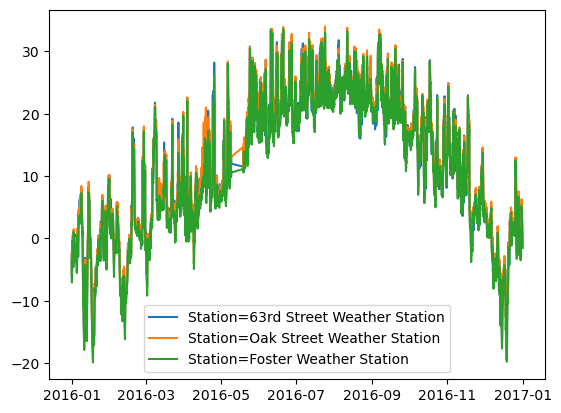

In [3]:
# plot the data to see what we are dealing with
for station in stations:
    plt.plot(data.loc[data['Station Name'] == station]['Measurement Timestamp'], data.loc[data['Station Name'] == station]['Air Temperature'],label=f'Station={station}')
plt.legend()
plt.show()### create timestamps in between the missing datapoints

# Create a full range of timestamps in 1-hour steps
full_range_timestamps = pd.date_range(
    start=data['Measurement Timestamp'].min(),
    end=data['Measurement Timestamp'].max(),
    freq='h'
)

# Create a DataFrame with the full range of timestamps
temp_df = pd.DataFrame({'Measurement Timestamp': full_range_timestamps})
for station in stations:
    station_data = data.loc[data['Station Name'] == station][['Measurement Timestamp', 'Air Temperature']]
    station_data = station_data.rename(columns={'Air Temperature': station})
    temp_df = temp_df.merge(station_data, on='Measurement Timestamp', how='left')

temp_df.set_index('Measurement Timestamp', inplace=True)
temp_df = temp_df.asfreq('h')
print(temp_df.isnull().sum())

In [5]:
### create timestamps in between the missing datapoints

# Create a full range of timestamps in 1-hour steps
full_range_timestamps = pd.date_range(
    start=data['Measurement Timestamp'].min(),
    end=data['Measurement Timestamp'].max(),
    freq='h'
)

# Create a DataFrame with the full range of timestamps
temp_df = pd.DataFrame({'Measurement Timestamp': full_range_timestamps})
for station in stations:
    station_data = data.loc[data['Station Name'] == station][['Measurement Timestamp', 'Air Temperature']]
    station_data = station_data.rename(columns={'Air Temperature': station})
    temp_df = temp_df.merge(station_data, on='Measurement Timestamp', how='left')

temp_df.set_index('Measurement Timestamp', inplace=True)
temp_df = temp_df.asfreq('h')
print(temp_df.isnull().sum())
print('Those are the number of missing entries in the dataset. A lot for oak street, but all of the stations have gaps')

63rd Street Weather Station     737
Oak Street Weather Station     1268
Foster Weather Station          661
dtype: int64
Those are the number of missing entries in the dataset. A lot for oak street, but all of the stations have gaps


In [7]:
# Analyze missing data
missing_data_summary = {}
for station in stations:
    missing_timestamps = temp_df[temp_df[station].isna()].index  # This index is datetime
    streaks = []
    streak_start = None

    # Identify streaks of missing values
    for idx in missing_timestamps:
        if streak_start is None:  # Start a new streak
            streak_start = idx
        elif idx != previous_timestamp + pd.Timedelta(hours=1):  # Non-consecutive timestamp
            streaks.append((streak_start, previous_timestamp))
            streak_start = idx  # Start a new streak
        previous_timestamp = idx

    # Add the final streak if it exists
    if streak_start is not None and previous_timestamp is not None:
        streaks.append((streak_start, previous_timestamp))

    # Calculate streak statistics
    streak_lengths = [(end - start).total_seconds() / 3600 + 1 for start, end in streaks]  # Streak lengths in hours
    longest_streak = max(streak_lengths, default=0)
    second_longest_streak = sorted(streak_lengths, reverse=True)[1] if len(streak_lengths) > 1 else 0
    longest_streak_start_end = streaks[streak_lengths.index(longest_streak)] if longest_streak > 0 else None
    second_longest_streak_start_end = streaks[streak_lengths.index(second_longest_streak)] if second_longest_streak > 0 else None

    # Store the summary
    missing_data_summary[station] = {
        "total_missing": len(missing_timestamps),
        "average_streak_length": sum(streak_lengths) / len(streak_lengths) if streak_lengths else 0,
        "longest_streak": longest_streak,
        "longest_streak_start_end": longest_streak_start_end,
        "second_longest_streak": second_longest_streak,
        "second_longest_streak_start_end": second_longest_streak_start_end
    }

# Convert the summary to a DataFrame for easy visualization
missing_summary_df = pd.DataFrame(missing_data_summary).T
missing_summary_df.columns = [
    "Total Missing",
    "Average Streak Length (hrs)",
    "Longest Streak (hrs)",
    "Longest Streak Start-End",
    "Second Longest Streak (hrs)",
    "Second Longest Streak Start-End"
]

missing_summary_df

,Total Missing,Average Streak Length (hrs),Longest Streak (hrs),Longest Streak Start-End,Second Longest Streak (hrs),Second Longest Streak Start-End
63rd Street Weather Station,737,4.946309,236.0,"(2016-05-09 14:00:00, 2016-05-19 09:00:00)",134.0,"(2016-04-04 10:00:00, 2016-04-09 23:00:00)"
Oak Street Weather Station,1268,2.374532,237.0,"(2016-05-09 13:00:00, 2016-05-19 09:00:00)",30.0,"(2016-02-07 05:00:00, 2016-02-08 10:00:00)"
Foster Weather Station,661,3.305,236.0,"(2016-05-09 14:00:00, 2016-05-19 09:00:00)",30.0,"(2016-02-07 05:00:00, 2016-02-08 10:00:00)"


There is an obvious gap in the data between 05-09 and 05-19. With other large gaps too

In [9]:
# Calculate the average temperature, excluding NaN values (average across the 3 stations)
temp_df['Average Temperature'] = temp_df[stations].mean(axis=1, skipna=True)
# Interpolate missing values using time interpolation
temp_df['Average Temperature'] = temp_df['Average Temperature'].interpolate(method='time', limit_direction='both')
temp_df_all_interpolated = temp_df.copy()
temp_df_all_interpolated = temp_df_all_interpolated.interpolate(method='time', limit_direction='both')
temp_df_all_interpolated

,63rd Street Weather Station,Oak Street Weather Station,Foster Weather Station,Average Temperature
Measurement Timestamp,,,,
2016-01-01 00:00:00,-2.8,-2.3,-3.67,-2.923333
2016-01-01 01:00:00,-3.4,-3.2,-4.56,-3.720000
2016-01-01 02:00:00,-4.2,-4.0,-5.50,-4.566667
2016-01-01 03:00:00,-5.1,-4.8,-6.28,-5.393333
2016-01-01 04:00:00,-5.7,-5.5,-7.00,-6.066667
...,...,...,...,...
2016-12-31 19:00:00,0.7,1.3,0.06,0.686667
2016-12-31 20:00:00,0.2,0.9,-0.28,0.273333
2016-12-31 21:00:00,-0.2,0.6,-0.67,-0.090000


In [10]:
print(data.isnull().sum())
print('Now there are no more gaps in the data')

Station Name             0
Measurement Timestamp    0
Air Temperature          0
dtype: int64
Now there are no more gaps in the data


In [12]:
daily_data = temp_df_all_interpolated.resample('d')
daily_data.agg({'Average Temperature': ['min','max','mean'],
                **{station:['mean'] for station in stations}})

Average Temperature                      \
                                      min       max      mean   
Measurement Timestamp                                           
2016-01-01                      -6.386667 -0.120000 -2.846389   
2016-01-02                      -4.353333  1.160000 -1.230347   
2016-01-03                      -3.230000 -0.095000 -1.718333   
2016-01-04                      -2.830000 -0.300000 -1.564861   
2016-01-05                      -4.933333  1.153333 -1.754236   
...                                   ...       ...       ...   
2016-12-27                      -2.590000 -0.663333 -1.558056   
2016-12-28                      -1.923333  7.123333  2.798750   
2016-12-29                       0.376667  2.633333  1.473056   
2016-12-30                      -2.866667  3.656667 -0.150000   
2016-12-31                      -1.053333  5.690000  3.066944   

                      63rd Street Weather Station Oak Street Weather Station  \
                                             mean                       mean   
Measurement Timestamp                                                          
2016-01-01                              -2.808333                  -2.275000   
2016-01-02                              -1.170833                  -0.802083   
2016-01-03                              -1.475000                  -1.266667   
2016-01-04                              -1.316667                  -1.206250   
2016-01-05                              -1.960417                  -1.020833   
...                                           ...                        ...   
2016-12-27                              -1.341667                  -0.987500   
2016-12-28                               2.558333                   3.570833   
2016-12-29                               1.554167                   1.979167   
2016-12-30                              -0.162500                   0.429167   
2016-12-31                               3.104167                   3.595833   

                      Foster Weather Station  
                                        mean  
Measurement Timestamp                         
2016-01-01                         -3.384167  
2016-01-02                         -1.649167  
2016-01-03                         -2.340208  
2016-01-04                         -2.150208  
2016-01-05                         -2.109583  
...                                      ...  
2016-12-27                         -2.345000  
2016-12-28                          2.267083  
2016-12-29                          0.885833  
2016-12-30                         -0.716667  
2016-12-31                          2.439792  

[366 rows x 6 columns]

In [14]:
# Resample the hourly dataset to daily frequency
daily_data = temp_df_all_interpolated.resample('d').agg({
    **{station: ['max', 'min', 'mean'] for station in stations},  # Aggregate max, min, and mean for each station
    'Average Temperature': ['max', 'min', 'mean']  # Include aggregated stats for the Average Temperature
})

# Flatten the multi-level column names
daily_data.columns = ['_'.join(col).strip() for col in daily_data.columns.values]

# Rename columns for clarity
column_rename_map = {}
for station in stations:
    column_rename_map[f'{station}_max'] = f'{station} Max'
    column_rename_map[f'{station}_min'] = f'{station} Min'
    column_rename_map[f'{station}_mean'] = f'{station} Mean'

daily_data = daily_data.rename(columns=column_rename_map)

# Include a column for overall daily statistics (e.g., max, min, mean across all stations)
daily_data['Overall Max'] = temp_df_all_interpolated[stations].resample('D').max().max(axis=1)
daily_data['Overall Min'] = temp_df_all_interpolated[stations].resample('D').min().min(axis=1)
daily_data['Overall Mean'] = temp_df_all_interpolated[stations].resample('D').mean().mean(axis=1)

daily_data

,63rd Street Weather Station Max,63rd Street Weather Station Min,63rd Street Weather Station Mean,Oak Street Weather Station Max,Oak Street Weather Station Min,Oak Street Weather Station Mean,Foster Weather Station Max,Foster Weather Station Min,Foster Weather Station Mean,Average Temperature_max,Average Temperature_min,Average Temperature_mean,Overall Max,Overall Min,Overall Mean
Measurement Timestamp,,,,,,,,,,,,,,,
2016-01-01,-0.3,-6.3,-2.808333,0.5,-5.8,-2.275000,-0.50,-7.06,-3.384167,-0.120000,-6.386667,-2.846389,0.5,-7.06,-2.822500
2016-01-02,1.2,-4.6,-1.170833,1.5,-3.9,-0.802083,1.00,-4.56,-1.649167,1.160000,-4.353333,-1.230347,1.5,-4.60,-1.207361
2016-01-03,0.7,-3.1,-1.475000,0.2,-2.7,-1.266667,-0.89,-3.89,-2.340208,-0.095000,-3.230000,-1.718333,0.7,-3.89,-1.693958
2016-01-04,0.4,-2.7,-1.316667,0.1,-2.5,-1.206250,-0.78,-3.39,-2.150208,-0.300000,-2.830000,-1.564861,0.4,-3.39,-1.557708
2016-01-05,1.3,-5.5,-1.960417,1.6,-3.8,-1.020833,0.56,-5.50,-2.109583,1.153333,-4.933333,-1.754236,1.6,-5.50,-1.696944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,-0.3,-2.5,-1.341667,-0.1,-2.1,-0.987500,-1.39,-3.28,-2.345000,-0.663333,-2.590000,-1.558056,-0.1,-3.28,-1.558056
2016-12-28,7.1,-2.2,2.558333,7.6,-1.1,3.570833,6.67,-2.67,2.267083,7.123333,-1.923333,2.798750,7.6,-2.67,2.798750
2016-12-29,2.8,0.4,1.554167,3.1,0.9,1.979167,2.00,-0.17,0.885833,2.633333,0.376667,1.473056,3.1,-0.17,1.473056


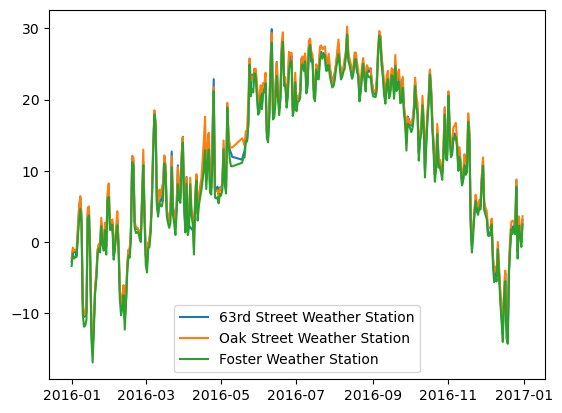

In [16]:
# plot, daily data
for station in stations:
    plt.plot(daily_data[f'{station} Mean'], label=station)
plt.legend()
plt.show()

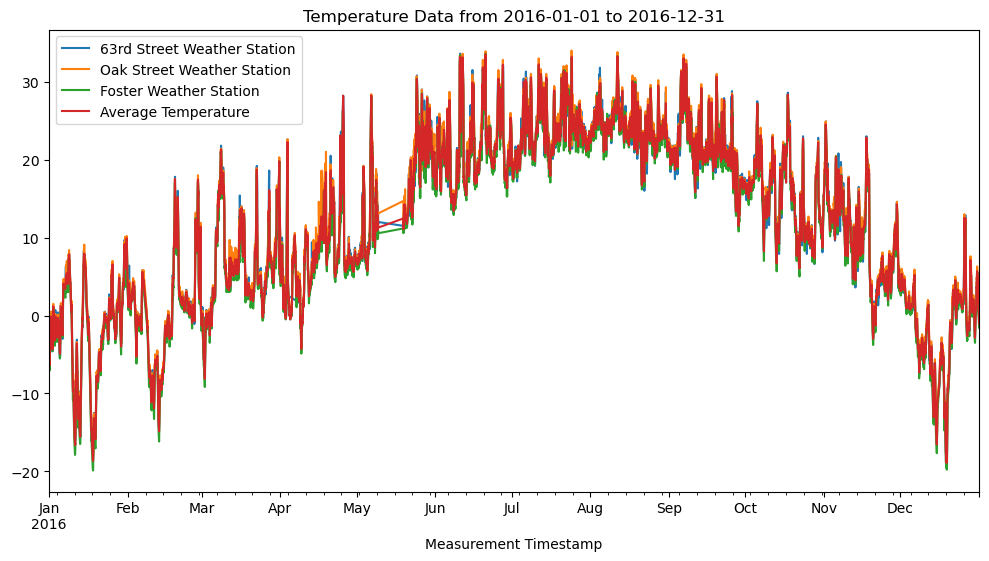

In [17]:
# Define the start and end dates
start_date = '2016-01-01'
end_date = '2016-12-31'

# Select the portion of the DataFrame between the dates
filtered_df = temp_df_all_interpolated.loc[start_date:end_date]

# Display the filtered DataFrame
# print(filtered_df)

## Visualize the filtered data
filtered_df.plot(title=f'Temperature Data from {start_date} to {end_date}', figsize=(12, 6))
plt.show()

## Analyze the data
Having looked at the data, now let's try to analyze it.

Start by removing the trend, seasonality

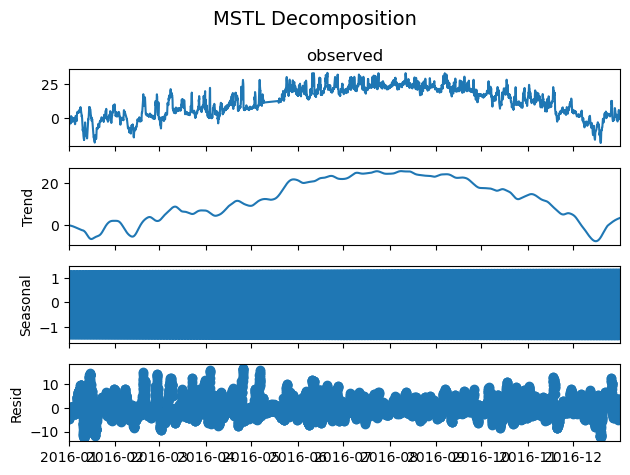

In [19]:
### remove seasonality
%matplotlib inline

from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult


frequencies = [24  ] #'#2*7*24, 3*7*24, 4*7*24]
windows = [701]
# Dictionary to store extracted seasonal components
seasonality_components = {}



# Resample and interpolate the data
station_data_resampled = temp_df_all_interpolated['Average Temperature']

# Convert the resampled data back to a pandas Series
station_series = pd.Series(station_data_resampled.values.reshape(-1),
                           index=pd.date_range(start=station_data_resampled.index.min(),
                                               periods=len(station_data_resampled),
                                               freq='h'))

# Perform MSTL decomposition with daily and weekly seasonalities
mstl = MSTL(station_series, periods=frequencies,windows=windows,  iterate=6, stl_kwargs={
    'robust':False,
    "trend":401, # Setting this large will force the trend to be smoother.
    "seasonal_deg":0, # Means the seasonal smoother is fit with a moving average.
     'trend_deg':1,
     })  # 24 for daily, 168 for weekly
mstl_result = mstl.fit()


# Extract the seasonal components
seasonal_df = mstl_result.seasonal
trend = mstl_result.trend
residual = mstl_result.resid

# Store the seasonal components
seasonality_components = {
    'Seasonal Df': seasonal_df,
    'Trend': trend,
    'Residual': residual,
}

# Plot the results
mstl_result.plot()
plt.suptitle(f'MSTL Decomposition', fontsize=14)
plt.tight_layout()
plt.show()

# seasonality_components now contains the extracted seasonalities, trend, and residuals for all stations


Now, look at the residual to see if there are any trends

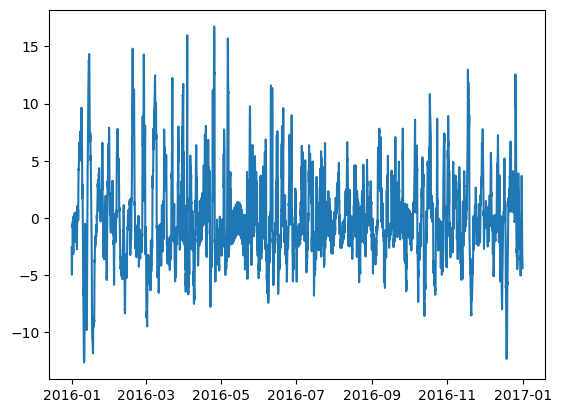

Residuals seem close to white noise, with no obvious pattern. There is a small deviation around May, which is where there was a gap of ~ 10 days worth of missing data


In [43]:
resid = seasonality_components['Residual']
season = seasonality_components['Seasonal Df']
trend = seasonality_components['Trend']
plt.plot(resid)
plt.show()
print('Residuals seem close to white noise, with no obvious pattern. There is a small deviation around May, which is where there was a gap of ~ 10 days worth of missing data')

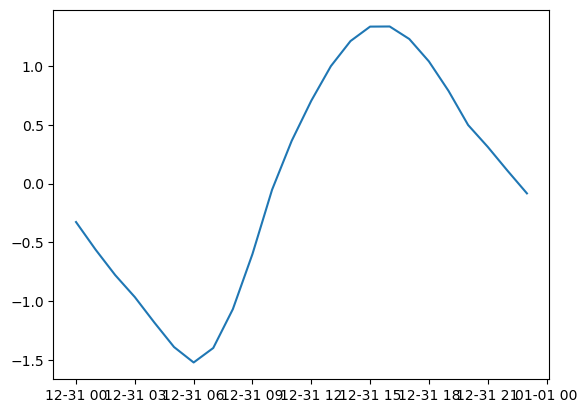

In [22]:
# look at the seasonality for 1 day
plt.plot(season.loc['2016-12-31':])
plt.show()

Let's continue analyzing the data. To start, let's look at the autocorrelation and partial autocorrelation plots for the residuals after extracting the seasonal and trend components

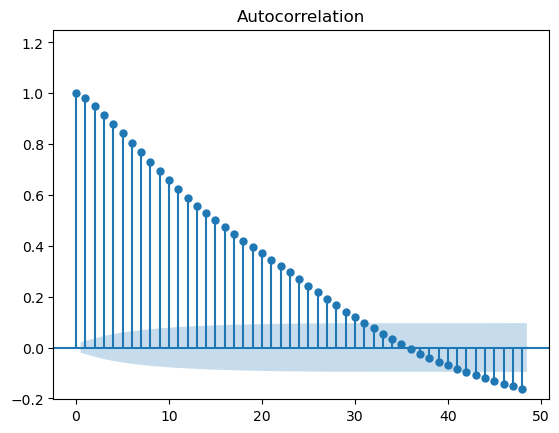

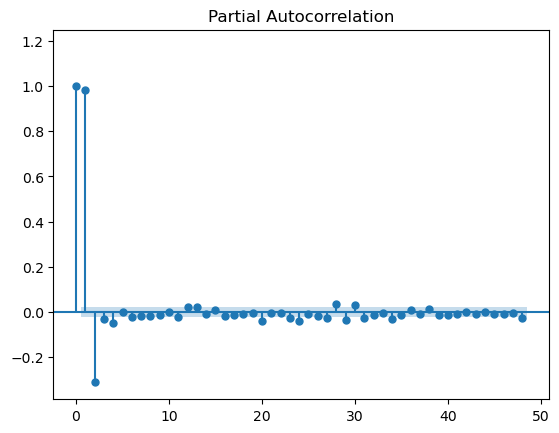

In [23]:
%matplotlib inline

plot_acf(resid,lags=24*2,auto_ylims=True)
plot_pacf(resid,lags=24*2,auto_ylims=True)
plt.show()


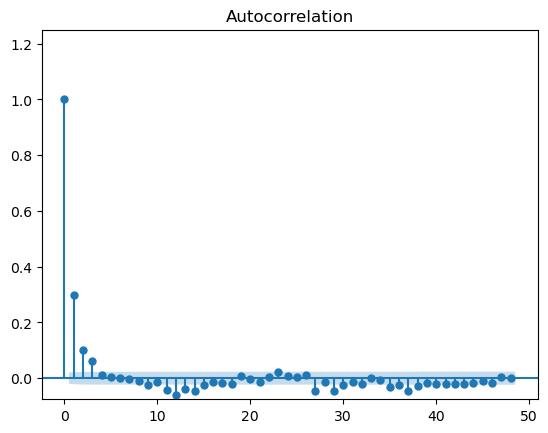

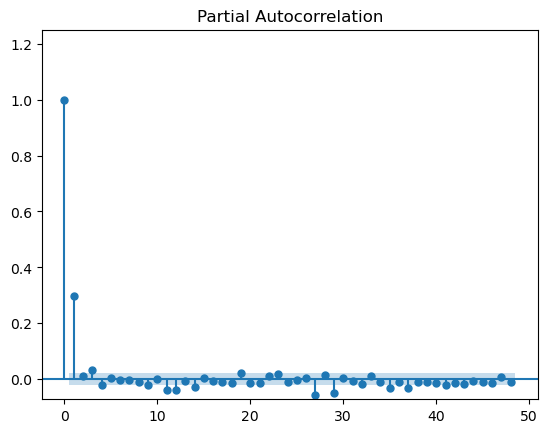

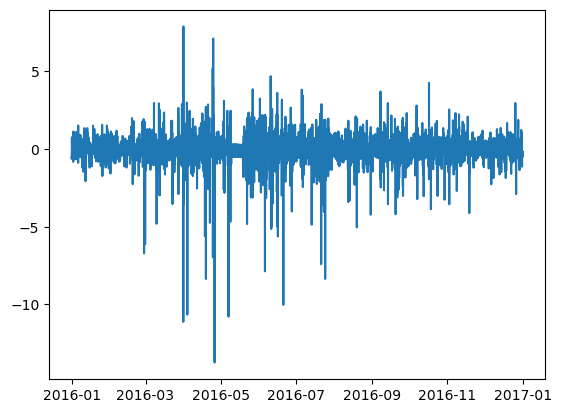

In [27]:
%matplotlib inline

plot_acf(resid.diff(1).dropna(),lags=24*2,auto_ylims=True)
plot_pacf(resid.diff(1).dropna(),lags=24*2,auto_ylims=True)
plt.show()
plt.plot(resid.diff(1).dropna())
plt.show()

Looks like differing by 1 hour might help, the ACF and PACF plots are simpler. But may not be needed

In [28]:
# do ADF test to check for stationarity
from statsmodels.tsa.stattools import adfuller

test_adf = adfuller(resid,maxlag=48,regression='c')
test_adf

(-13.884554244997412,
 6.123820653494852e-26,
 33,
 8750,
 {'1%': -3.431097567935713,
  '5%': -2.8618703753609926,
  '10%': -2.566945853831837},
 18986.635783696533)

The p-value of the ADF test is very low, so the residuals are stationary so we can model them using models that assume stationarity

## Create Model, then predict
Given the nature of the data (stationary, with possibly mild seasonality leftover after MSTL), a SARIMA model could do well. I will use sktime AutoARIMA to model the time series in this case, optimizing for the AIC

Fitting models using approximations to speed things up

ARIMA(2,1,2)(2,1,1)[24]                   :604.5469591359936

ARIMA(0,1,0)(0,1,0)[24]                   :1166.7991955576763

ARIMA(1,1,0)(1,1,0)[24]                   :715.6019677215681

ARIMA(0,1,1)(0,1,1)[24]                   :inf

ARIMA(2,1,2)(1,1,1)[24]                   :634.2725265271562

ARIMA(2,1,2)(2,1,0)[24]                   :659.297638862895

ARIMA(2,1,2)(2,1,2)[24]                   :inf

ARIMA(2,1,2)(1,1,0)[24]                   :717.519190414124

ARIMA(2,1,2)(1,1,2)[24]                   :inf

ARIMA(1,1,2)(2,1,1)[24]                   :603.092300566631

ARIMA(1,1,2)(1,1,1)[24]                   :637.9525353948383

ARIMA(1,1,2)(2,1,0)[24]                   :657.3029029478438

ARIMA(1,1,2)(2,1,2)[24]                   :inf

ARIMA(1,1,2)(1,1,0)[24]                   :715.4980352680449

ARIMA(1,1,2)(1,1,2)[24]                   :inf

ARIMA(0,1,2)(2,1,1)[24]                   :660.4152812087101

ARIMA(1,1,1)(2,1,1)[24] 

/opt/anaconda3/lib/python3.12/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsforecast/arima.py:479: User


ARIMA(1,1,3)(2,1,1)[24]                   :602.5154692101667

ARIMA(1,1,3)(1,1,1)[24]                   :639.5329263294357

ARIMA(1,1,3)(2,1,0)[24]                   :657.4784318863489

ARIMA(1,1,3)(2,1,2)[24]                   :inf

ARIMA(1,1,3)(1,1,0)[24]                   :715.6021015971063

ARIMA(1,1,3)(1,1,2)[24]                   :inf

ARIMA(0,1,3)(2,1,1)[24]                   :619.3975876929044

ARIMA(2,1,3)(2,1,1)[24]                   :604.5300036416769

ARIMA(1,1,4)(2,1,1)[24]                   :604.5942887032899

ARIMA(0,1,4)(2,1,1)[24]                   :inf

ARIMA(2,1,4)(2,1,1)[24]                   :606.3465117275598
Now re-fitting the best model(s) without approximations...



/opt/anaconda3/lib/python3.12/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsforecast/arima.py:479: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsforecast/arima.py:479: User


ARIMA(1,1,3)(2,1,1)[24]                   :449.30023360017975
(1, 3, 2, 1, 24, 1, 1)

Prediction completed successfully.


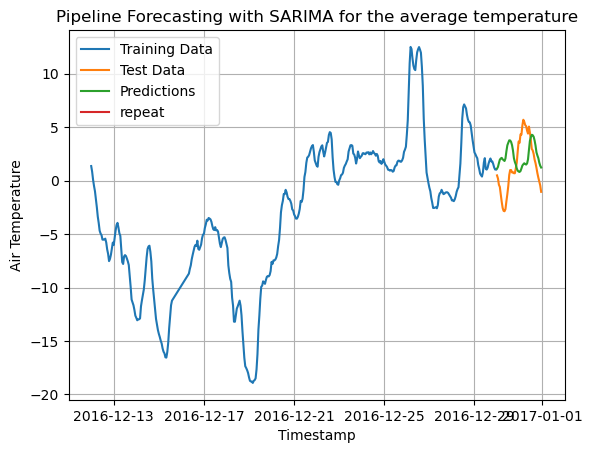

In [46]:
%matplotlib inline

from sktime.forecasting.compose import TransformedTargetForecaster
from sktime. split import temporal_train_test_split
from sktime.transformations.series.detrend import MSTL
from sktime.forecasting.arima import AutoARIMA, ARIMA
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA, StatsForecastMSTL
from sktime.forecasting.naive import NaiveForecaster
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

# Split the data into train and test sets
number_of_dats_to_train = 20
number_of_days_to_test = 2
station_data_short = resid.iloc[-24*number_of_dats_to_train:]
y_train, y_test = temporal_train_test_split(station_data_short, test_size=24*2)



# Define the pipeline
# forecaster = ARIMA(order=(2,0,2),seasonal_order=(0,1,2,24),)
forecaster = StatsForecastAutoARIMA(sp=24,d=1,D=1,start_p=2,start_P=2,trace=True)#(order=(2,0,2),seasonal_order=(0,1,2,24),)



forecaster.fit(y_train)
print(forecaster.get_fitted_params()['model']['arma'])
# print('station:',station,' ',pipeline.steps_[-1][-1].get_fitted_params()['model']['arma'])

# Make predictions
extra_days = 0 # if want to predict into the future, beyond the available data. In this case, copy the data from the start of the dataset (assume perfect periodicity)
fh = range(1, len(y_test) + 1 + 24*extra_days)  # Forecasting horizon
y_pred = forecaster.predict(fh)
print("\nPrediction completed successfully.")


# Training data
plt.plot(y_train+season[y_train.index]+trend[y_train.index], label='Training Data')

# Test data
plt.plot(y_test+season[y_test.index]+trend[y_test.index], label='Test Data')

# Predictions
plt.plot(y_pred.index, y_pred+season[y_pred.index]+trend[y_pred.index], label='Predictions')
extra_days_time = pd.date_range(
    start=y_test.index.max()+pd.DateOffset(hours=1),
    end=(y_test.index.max()+ pd.DateOffset(days=extra_days,hours=1)).floor('h'),
    freq='h')

plt.plot(extra_days_time,resid[:len(extra_days_time)],label='repeat')
plt.title(f"Pipeline Forecasting with SARIMA for the average temperature")
plt.xlabel('Timestamp')
plt.ylabel('Air Temperature')
plt.legend()
plt.grid()
plt.show()


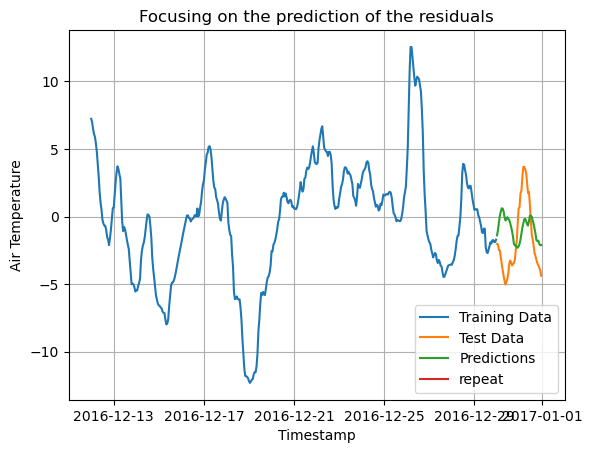

In [47]:
# Training data
plt.plot(y_train, label='Training Data')

# Test data
plt.plot(y_test, label='Test Data')

# Predictions
plt.plot(y_pred.index, y_pred, label='Predictions')
extra_days_time = pd.date_range(
    start=y_test.index.max()+pd.DateOffset(hours=1),
    end=(y_test.index.max()+ pd.DateOffset(days=extra_days,hours=1)).floor('h'),
    freq='h')

plt.plot(extra_days_time,resid[:len(extra_days_time)],label='repeat')
plt.title(f"Focusing on the prediction of the residuals")
plt.xlabel('Timestamp')
plt.ylabel('Air Temperature')
plt.legend()
plt.grid()
plt.show()

In [50]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'The RMSE is {rmse:.2f} degrees celcius, not too bad')

The RMSE is 2.86 degrees celcius, not too bad


## Conclusions
- Modeled the data using a SARIMA model. The RMSE is ~2.9 degrees celcius for predicting over a 2 day period.
- Since the data spans only 1 year, predicting in the future would require extrapolating. The seasonal pattern from MSTL is already periodic. The trend (which is in fact just the annual seasonality) can be modelled by repeating the same pattern, or extracting the fourier components after stitching a few copies together.
- A more in depth analysis of hyperparameters, and changing models (e.g. trying NeuralForecast) would be a nice addition.
- To improve the model, one could use additional exogenous variables such as the pressure, humidity, wind speed, etc.
